In [285]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.compat import lzip
from statsmodels.stats.diagnostic import het_breuschpagan
from scipy.stats import t, shapiro
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, PolynomialFeatures, OneHotEncoder, LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error

In [362]:
df_train_modify = pd.read_csv('../../csv/train_modifie_mickael.csv')
df_test_modify = pd.read_csv('../../csv/test_modifie_mickael.csv')

In [363]:
df_train = df_train_modify.drop(['Unnamed: 0', 'count'], axis=1)
df_test = df_test_modify.drop(['Unnamed: 0', 'count'], axis=1)

In [288]:
X_train = df_train.drop(['registered', 'casual'], axis=1)
y_train_registered = df_train['registered']
y_train_casual = df_train['casual']

In [289]:
X_test = df_test.drop(['registered', 'casual'], axis=1)
y_test_registered = df_test['registered']
y_test_casual = df_test['casual']

# Preprocessing

In [292]:
#Features et pipelines
scaled_features = ['temp', 'atemp', 'windspeed', 'humidity'] 
scaled_pipeline = make_pipeline(StandardScaler(), PolynomialFeatures(degree=3))
encoded_features = ['season','weather','workingday', 'holiday', 'week_days', 'months', 'hours']
encoded_pipeline = make_pipeline(OneHotEncoder())

#preprocessing et main pipeline
preprocessor = make_column_transformer((scaled_pipeline, scaled_features),(encoded_pipeline, encoded_features))

In [293]:
X_test_new = preprocessor.fit_transform(X_test)
X_test_new_df = pd.DataFrame(X_test_new)

features_name = {}
for i in range(X_test_new.shape[1]):
    features_name[i] = preprocessor.get_feature_names_out()[i].replace(" ","").replace("^","_").replace('pipeline-1__','').replace('pipeline-2__','')
X_test_new_df = X_test_new_df.rename(columns=features_name)

X_train_new = preprocessor.fit_transform(X_train)
X_train_new_df = pd.DataFrame(X_train_new)

features_name = {}
for i in range(X_train_new.shape[1]):
    # features_name[i] = poly_features.get_feature_names_out()[i].replace(" ","").replace("^","_")
    features_name[i] = preprocessor.get_feature_names_out()[i].replace(" ","").replace("^","_").replace('pipeline-1__','').replace('pipeline-2__','')
X_train_new_df = X_train_new_df.rename(columns=features_name)
df_new_registered = X_train_new_df.join(y_train_registered)
df_new_casual = X_train_new_df.join(y_train_casual)

In [294]:
formula = 'registered ~ '
max = X_train_new.shape[1]
for i in range(0,max):
    if i != max-1:
        formula += preprocessor.get_feature_names_out()[i] + ' + '
    if i == max-1:
        formula += preprocessor.get_feature_names_out()[i]
# formula = formula.replace(" ","").replace("^","_")
formula = formula.replace(" ","").replace("^","_").replace('pipeline-1__','').replace('pipeline-2__','')

In [295]:
ols_model = smf.ols(formula, data=df_new_registered)
# ols_model = sm.OLS(y_train,X_train_new)
ols_res = ols_model.fit()
print(ols_res.summary())

                            OLS Regression Results                            
Dep. Variable:             registered   R-squared:                       0.653
Model:                            OLS   Adj. R-squared:                  0.650
Method:                 Least Squares   F-statistic:                     216.5
Date:                Wed, 23 Mar 2022   Prob (F-statistic):               0.00
Time:                        17:04:14   Log-Likelihood:                -52853.
No. Observations:                9063   AIC:                         1.059e+05
Df Residuals:                    8984   BIC:                         1.064e+05
Df Model:                          78                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 42

In [296]:
pvalue = 2
index = ''
features_to_delete = []
while True:
    formula = formula.replace('+' + index + '+', '+')
    ols_model = smf.ols(formula, data=df_new_registered)
    ols_res = ols_model.fit()
    pvalues = ols_res.pvalues[1:]
    index = pvalues[pvalues == pvalues.max()].index[0]
    pvalue = pvalues[pvalues == pvalues.max()].values[0]
    if (pvalue > 0.05) & (index != 'intercept'):
        print('La variable ' + index + ' de p-value ' + '{:01.3f}'.format(pvalue) + ' n\'est pas significative. On la supprime.')
        features_to_delete.append(index)
    else:
        break

features_list = list(features_name.values())
for i in range(len(features_to_delete)):
    j = features_list.index(features_to_delete[i])
    X_train_new_df = X_train_new_df.drop(features_name[j], axis=1)
    if features_name[j] in X_test_new_df.columns:
        X_test_new_df = X_test_new_df.drop(features_name[j], axis=1)
df_new_registered = X_train_new_df.join(y_train_registered)

La variable hours_15 de p-value 0.963 n'est pas significative. On la supprime.
La variable tempatempwindspeed de p-value 0.910 n'est pas significative. On la supprime.
La variable atempwindspeed de p-value 0.831 n'est pas significative. On la supprime.
La variable windspeed_2humidity de p-value 0.802 n'est pas significative. On la supprime.
La variable months_7 de p-value 0.778 n'est pas significative. On la supprime.
La variable week_days_6 de p-value 0.520 n'est pas significative. On la supprime.
La variable atemphumidity_2 de p-value 0.496 n'est pas significative. On la supprime.
La variable atemp de p-value 0.546 n'est pas significative. On la supprime.
La variable weather_3 de p-value 0.487 n'est pas significative. On la supprime.
La variable months_10 de p-value 0.493 n'est pas significative. On la supprime.
La variable atemphumidity de p-value 0.453 n'est pas significative. On la supprime.
La variable atemp_2humidity de p-value 0.448 n'est pas significative. On la supprime.
La v

In [280]:
ols_model = smf.ols(formula, data=df_new_registered)
# ols_model = sm.OLS(y_train,X_train_new)
ols_res = ols_model.fit()
print(ols_res.summary())

                            OLS Regression Results                            
Dep. Variable:             registered   R-squared:                       0.658
Model:                            OLS   Adj. R-squared:                  0.654
Method:                 Least Squares   F-statistic:                     162.5
Date:                Wed, 23 Mar 2022   Prob (F-statistic):               0.00
Time:                        16:54:47   Log-Likelihood:                -52624.
No. Observations:                9039   AIC:                         1.055e+05
Df Residuals:                    8932   BIC:                         1.062e+05
Df Model:                         106                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept   

### Calcul des leviers de la matrice de projection : données atypiques sur les variables explicatives

In [344]:
alpha = 0.05 # On pose un seuil de significativité à 5%
n = df_new_registered.shape[0] # Nombre d'observations
p = df_new_registered.shape[1] # Nombre de features

In [345]:
analyses = pd.DataFrame({'obs':np.arange(1, n+1)})

In [346]:
analyses['levier'] = ols_res.get_influence().hat_matrix_diag
seuil_levier = 2*p/n

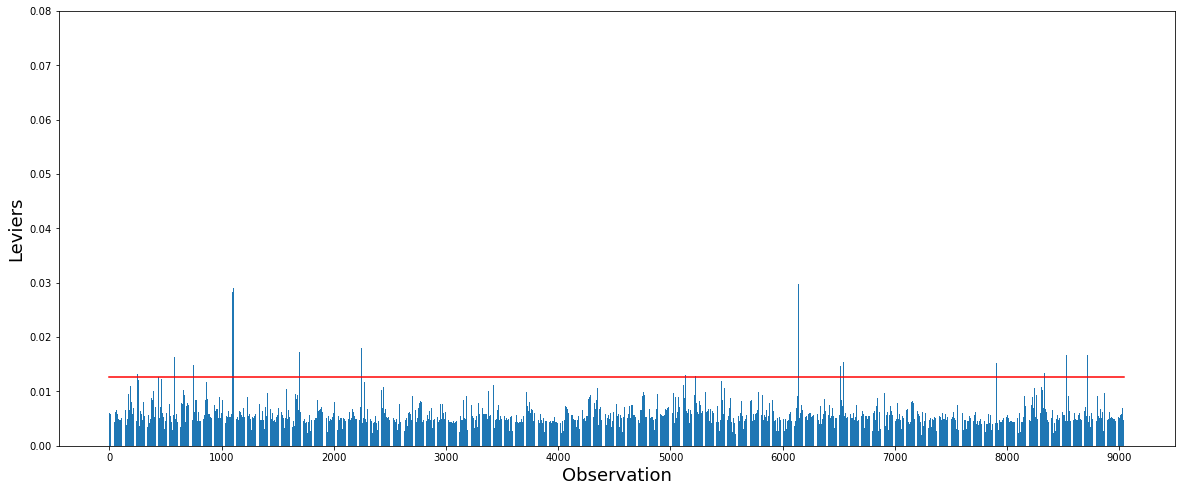

In [182]:
plt.figure(figsize=(20,8))
plt.bar(analyses['obs'], analyses['levier'])
plt.xticks(np.arange(0, n+1, step=1000))
plt.xlabel('Observation',fontsize=18)
plt.ylabel('Leviers',fontsize=18)
plt.plot([0, n+1], [seuil_levier, seuil_levier], color='r')
plt.show()

### Calcul des résidus studentisés internes : données atypiques sur la variable cible

In [347]:
analyses['rstudent'] = ols_res.get_influence().resid_studentized_internal
seuil_rstudent = t.ppf(1-alpha/2,n-p-1)

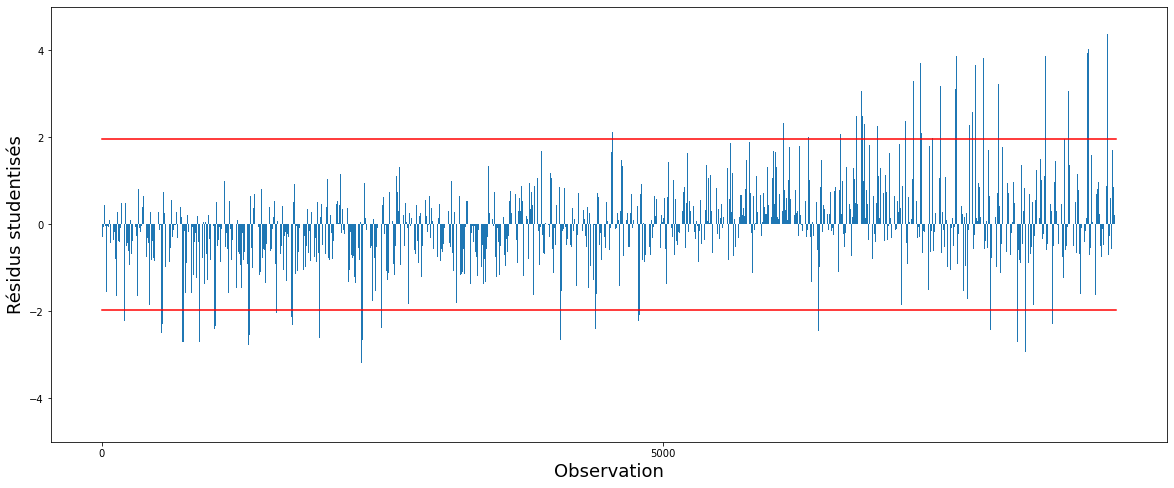

In [184]:
plt.figure(figsize=(20,8))
plt.bar(analyses['obs'], analyses['rstudent'])
plt.xticks(np.arange(0, n+1, step=5000))
plt.xlabel('Observation',fontsize=18)
plt.ylabel('Résidus studentisés',fontsize=18)
plt.ylim([-5,5])
plt.plot([0, n+1], [seuil_rstudent, seuil_rstudent], color='r')
plt.plot([0, n+1], [-seuil_rstudent, -seuil_rstudent], color='r')
plt.show()

### Calcul de la distance de Cook : données influentes

In [355]:
dcooks = pd.DataFrame(ols_res.get_influence().cooks_distance[0],columns=['d_cooks'])
analyses['dcooks'] = dcooks['d_cooks']
seuil_dcook = 4/(n-p)

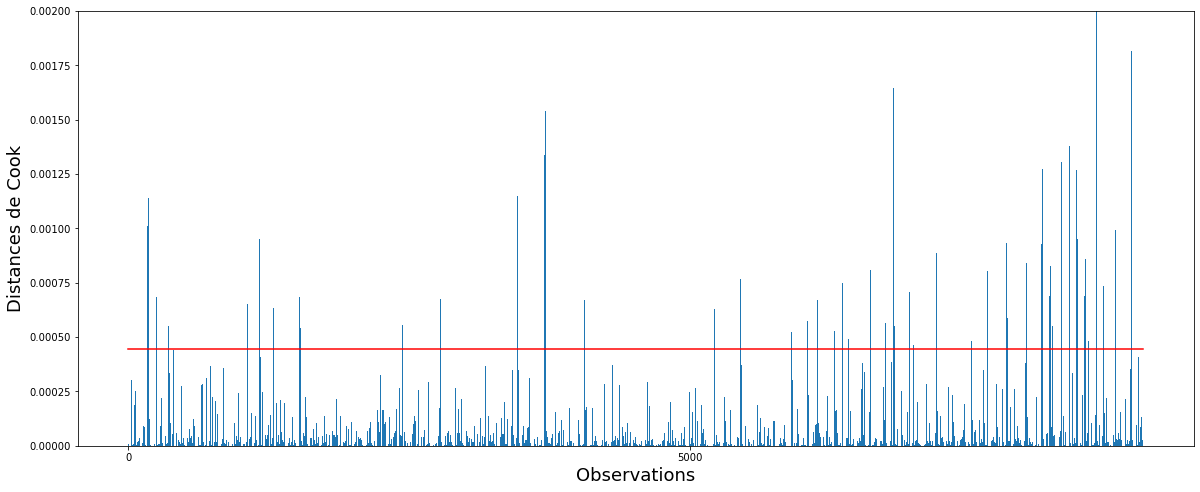

In [186]:
plt.figure(figsize=(20,8))
plt.bar(analyses['obs'], analyses['dcooks'])
plt.xticks(np.arange(0, n+1, step=5000))
plt.xlabel('Observations',fontsize=18)
plt.ylabel('Distances de Cook',fontsize=18)
plt.ylim([0,0.002])
plt.plot([0, n+1], [seuil_dcook, seuil_dcook], color='r')
plt.show()

### Données atypiques et influentes

In [356]:
atypiques_et_influents = analyses.loc[(analyses['levier'] > seuil_levier) &
                                      (analyses['rstudent'] > seuil_rstudent) &
                                      (analyses['dcooks'] > seuil_dcook), :]
atypiques_et_influents_df = df_new_registered.iloc[atypiques_et_influents.index.to_numpy()]

In [357]:
a = list(atypiques_et_influents_df.index)

In [359]:
outliers = df_train.loc[a]

In [360]:
df_no_outliers = df_train.drop(a)

<AxesSubplot:xlabel='atemp', ylabel='temp'>

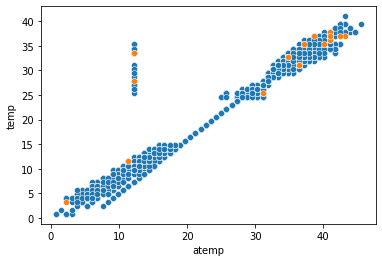

In [361]:
col = 'atemp'
sns.scatterplot(x=col,y='temp',data=df_no_outliers)
sns.scatterplot(x=col,y='temp',data=outliers)

### Suppression des données atypiques et influentes

In [261]:
for row in atypiques_et_influents_df.index:
    df_new = df_new_registered.drop(row)
    X_train_new_df = X_train_new_df.drop(row)
    y_train_registered = y_train_registered.drop(row)

In [262]:
ols_model = smf.ols(formula, data=df_new)
# ols_model = sm.OLS(y_train,X_train_new)
ols_res = ols_model.fit()
print(ols_res.summary())

                            OLS Regression Results                            
Dep. Variable:             registered   R-squared:                       0.651
Model:                            OLS   Adj. R-squared:                  0.649
Method:                 Least Squares   F-statistic:                     341.4
Date:                Wed, 23 Mar 2022   Prob (F-statistic):               0.00
Time:                        16:52:11   Log-Likelihood:                -52721.
No. Observations:                9038   AIC:                         1.055e+05
Df Residuals:                    8988   BIC:                         1.059e+05
Df Model:                          49                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              49.2725    